# Swiss Population basic Analysis

## Swiss Data
This dataset is provided by the swiss government. It contains yearly data (from 1981 till 2020) on the population of every canton, district and municipality in switzerland by gender. To download it, use the this [link](https://www.pxweb.bfs.admin.ch/pxweb/en/px-x-0102020000_201/px-x-0102020000_201/px-x-0102020000_201.px).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
pop_df = pd.read_excel('data/px-x-0102020000_201_20220406-142814.xlsx',header=2)

## Preprocessing

This data is made to be read in an excel file to we will have to slightly reformat it a bit

In [3]:
pop_df.head(4)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Population on 1 January
0,1981,1981.0,Switzerland,Citizenship (category) - total,Sex - total,6335243.0
1,NaN,NaN,NaN,NaN,Male,3081965.0
2,NaN,NaN,NaN,NaN,Female,3253278.0
3,NaN,NaN,- Zürich,Citizenship (category) - total,Sex - total,1120815.0


Let's first rename the unnamed columns, drop the irrelevant ones and fill NaN values with their actual value. Finally, we remove the last rows of the dataframe because they have nothing to do with the data.

In [4]:
pop_df = pop_df.rename(columns ={'Unnamed: 4': 'population_type', 'Unnamed: 2': 'region', 'Unnamed: 1': 'year'}) \
                .drop(columns = ['Unnamed: 3','Unnamed: 0']) \
                .fillna(method="ffill")
pop_df = pop_df[pop_df.region != 'Unknown']
pop_df

,year,region,population_type,Population on 1 January
0,1981.0,Switzerland,Sex - total,6335243.0
1,1981.0,Switzerland,Male,3081965.0
2,1981.0,Switzerland,Female,3253278.0
3,1981.0,- Zürich,Sex - total,1120815.0
4,1981.0,- Zürich,Male,541902.0
...,...,...,...,...
284632,2020.0,......6809 Haute-Ajoie,Male,549.0
284633,2020.0,......6809 Haute-Ajoie,Female,536.0
284634,2020.0,......6810 La Baroche,Sex - total,1142.0
284635,2020.0,......6810 La Baroche,Male,589.0


The names in the `region` column have a coded writing:
* Names starting with the character `-` indicate that the region is a canton
* Names starting with the character `>>` indicate that the region is a district
* Names starting with the character `......` indicate that the region is a municipality. The number after that is the municipalitie's `BFS_NUMBER` (a unique id of the municipality provided by the swiss government)
* Names starting with no special character indicate a country

Instead of having this coded writing, we will add a column named `region_type` indicating whether the region is a canton, a district, a commune or a country. Additionally, we will add the column `bfs_nb` which will have the bfs number of the commune (if it is one, otherwise we will put a NaN).

In [5]:
def assign_region_type(region):
    if region[0] == '-':
        return 'canton'
    elif region[:2] == '>>':
        return 'district'
    elif region[:6] == '......':
        return 'commune'
    else:
        return 'country'


pop_df['region_type'] = pop_df.region.apply(assign_region_type)
pop_df['bfs_nb'] = pop_df.region.apply(lambda x: re.findall(r'^\D*(\d+)', x)[0] if x[:6] == '......' else np.nan)


Now that we have added these two features let's remove this coded writing from the `region` column

In [6]:

def clean_region(region):
    words = region.split()
    if len(words) > 1:
        return ' '.join(words[1:])
    else:
        return words[0]
    

pop_df['region'] = pop_df.region.apply(clean_region)
pop_df['Population on 1 January'] = pop_df['Population on 1 January'].apply(int)
pop_df['year'] = pop_df['year'].apply(int)

In [15]:
pop_df.head(10)

,year,region,population_type,Population on 1 January,region_type,bfs_nb
0,1981,Switzerland,Sex - total,6335243,country,NaN
1,1981,Switzerland,Male,3081965,country,NaN
2,1981,Switzerland,Female,3253278,country,NaN
3,1981,Zürich,Sex - total,1120815,canton,NaN
4,1981,Zürich,Male,541902,canton,NaN
5,1981,Zürich,Female,578913,canton,NaN
6,1981,Bezirk Affoltern,Sex - total,29374,district,NaN
7,1981,Bezirk Affoltern,Male,14821,district,NaN
8,1981,Bezirk Affoltern,Female,14553,district,NaN
9,1981,Aeugst am Albis,Sex - total,867,commune,0001


## Basic statistics and insights of data

Let's first take a look at the basic statistics on the population

In [20]:
pop_df.describe()

,year,Population on 1 January
count,284520.000000,2.845200e+05
mean,2000.500000,8.213470e+03
std,11.543417,1.115277e+05
min,1981.000000,0.000000e+00
25%,1990.750000,3.830000e+02
50%,2000.500000,9.340000e+02
75%,2010.250000,2.522000e+03
max,2020.000000,8.606033e+06


The data seems clean and doesn't seem to have any outliers

Finally, let's look at the histograms of the population in 2020 by commune and by canton: 

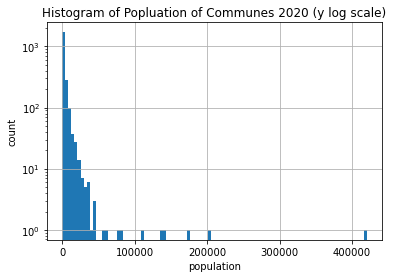

In [16]:
mask = ((pop_df['population_type'] == 'Sex - total') & (pop_df['region_type'] == 'commune') & (pop_df['year'] == 2020))
pop_df[mask]['Population on 1 January'].hist(bins = 100)
plt.title('Histogram of Popluation of Communes 2020 (y log scale)')
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('population')
plt.show()

As we can see (and also as expected), the population per commune is right skewed.

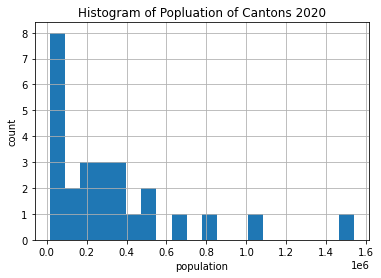

In [19]:
mask = ((pop_df['population_type'] == 'Sex - total') & (pop_df['region_type'] == 'canton') & (pop_df['year'] == 2020))
pop_df[mask]['Population on 1 January'].hist(bins = 20)
plt.title('Histogram of Popluation of Cantons 2020')
plt.ylabel('count')
plt.xlabel('population')
plt.show()

As we can see (and also as expected), the population per commune is right skewed.